In [1]:
import healpy as hp
import numpy as np
import os
import astropy.units as u
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel16
%matplotlib inline

Visualize the diffuse emission first to recall how to do this

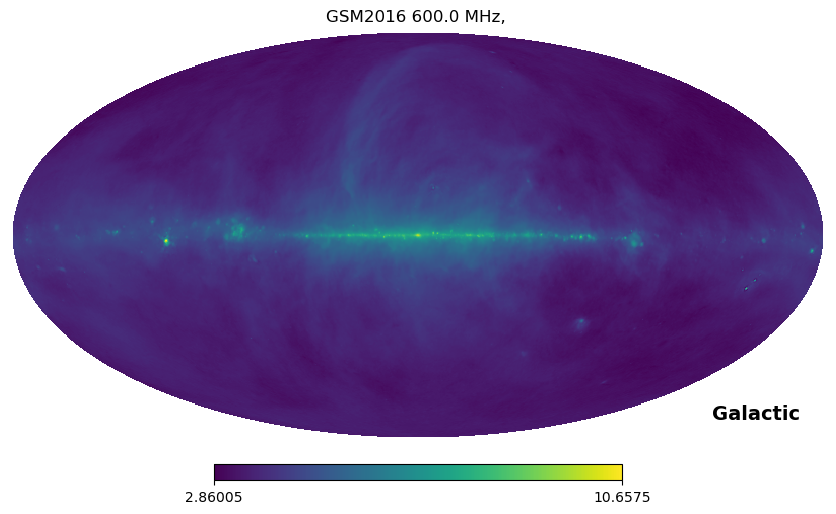

In [2]:
gsm = GlobalSkyModel16(freq_unit='MHz', resolution='hi')
gsm.generate(600) #generate the map at 500 MHz
gsm.view(logged=True)

Note that gsm files are already stored as Numpy arrays

In [3]:
sm = gsm.generate(200)
print(sm.shape)
print(type(sm))

(12582912,)
<class 'numpy.ndarray'>


In [4]:
nside = 1024 #default nside from GSM generate
lmax = 2*nside
C_l = hp.anafast(sm, lmax=lmax)


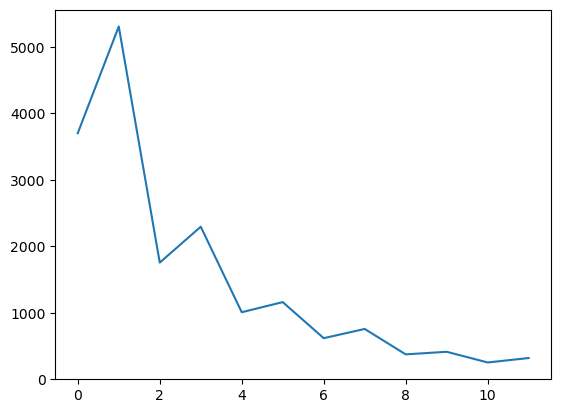

In [5]:
plt.plot(C_l[3:15])

Computing, instead, the a_lms

In [6]:
a_lm = hp.map2alm(sm, lmax=lmax)

If we wanted PS only, could just use this formula which performs the same thing (seemingly) as anafast.

In [7]:
cl = hp.alm2cl(a_lm)

[ 6.80082410e+02+0.00000000e+00j  1.52922769e+01+0.00000000e+00j
 -2.69405636e+02+0.00000000e+00j ...  2.14524098e-03-4.10638501e-04j
 -1.36339281e-03-8.70575122e-05j  1.00923165e-03-1.36854595e-03j]


/home/mike/anaconda3/envs/corrcal_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mike/anaconda3/envs/corrcal_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


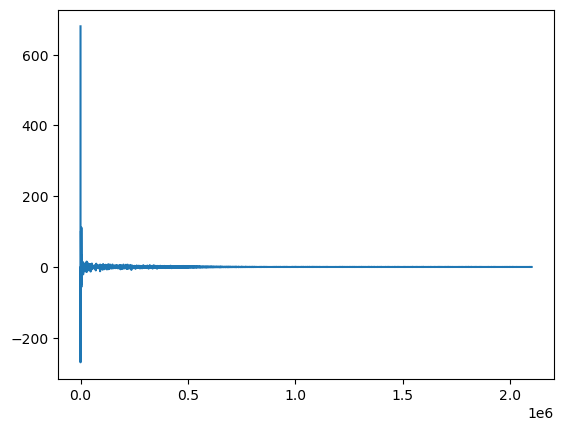

In [8]:
print(a_lm)
plt.plot(a_lm)

Number of coefficients: 33153
Example coefficient a_{10,0} = -2.149e+02+0.000e+00j


/tmp/ipykernel_2605/2454743408.py:36: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  recon = hp.alm2map(alm, nside=nside, lmax=lmax, verbose=False)


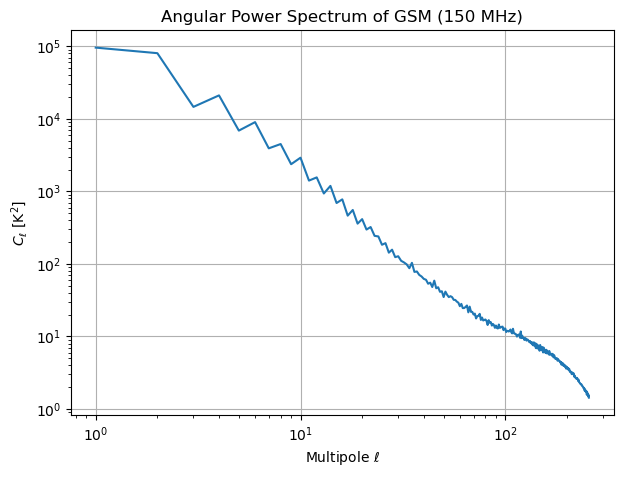

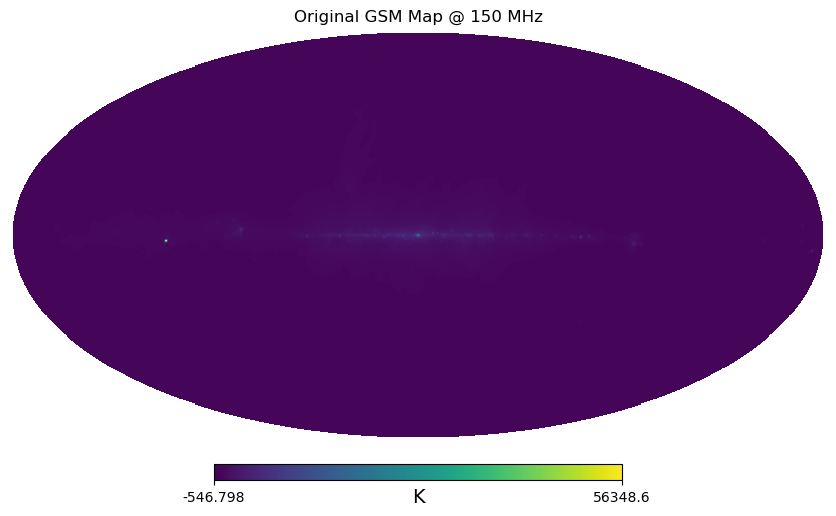

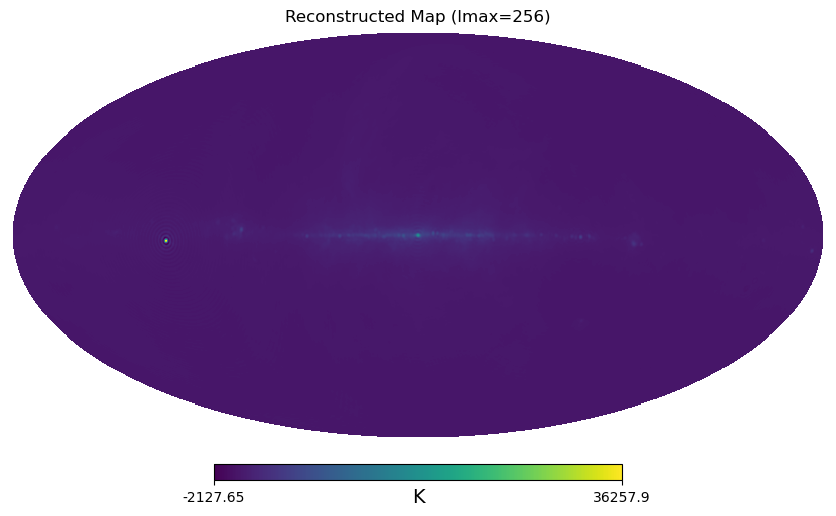

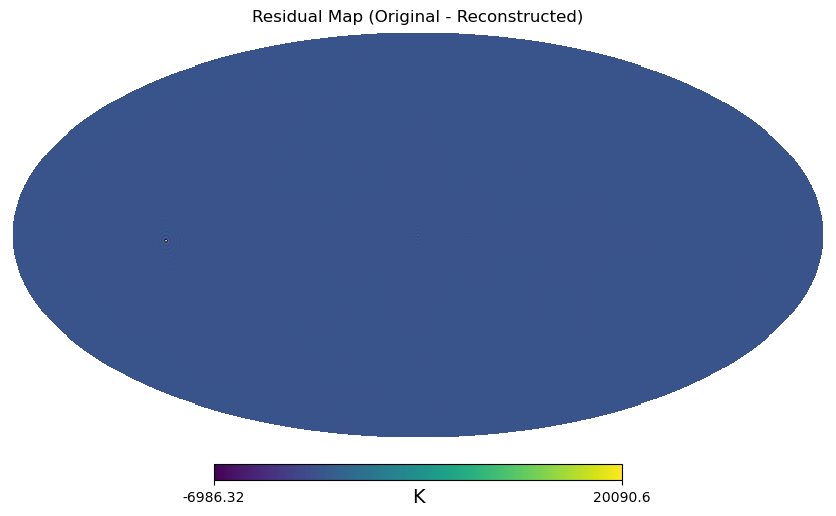

In [9]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel16

# ----------------------------
# 1. Generate a sky map (in Kelvin)
# ----------------------------
gsm = GlobalSkyModel16()
freq = 150  # MHz
sky = gsm.generate(freq)  # shape = (N_pix,)

nside = hp.get_nside(sky)
lmax = 256  # maximum multipole for harmonic decomposition

# ----------------------------
# 2. Compute spherical harmonic coefficients a_{ℓm}
# ----------------------------
alm = hp.map2alm(sky, lmax=lmax)

print(f"Number of coefficients: {alm.size}")
print(f"Example coefficient a_{{10,0}} = {alm[hp.Alm.getidx(lmax, 10, 0)]:.3e}")

# ----------------------------
# 3. Compute the angular power spectrum C_ℓ = <|a_{ℓm}|²>
# ----------------------------
cl = hp.alm2cl(alm)

# Convert multipole ℓ to approximate angular scale in degrees
ell = np.arange(len(cl))
theta_deg = 180.0 / (ell + 0.5)

# ----------------------------
# 4. Reconstruct the map from a_{ℓm}
# ----------------------------
recon = hp.alm2map(alm, nside=nside, lmax=lmax, verbose=False)

# ----------------------------
# 5. Plot the results
# ----------------------------

plt.figure(figsize=(7,5))
plt.loglog(ell[1:], cl[1:])
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$ [K$^2$]')
plt.title('Angular Power Spectrum of GSM (150 MHz)')
plt.grid(True)
plt.show()

# Original vs reconstructed map
hp.mollview(sky, title=f'Original GSM Map @ {freq} MHz', unit='K')
hp.mollview(recon, title=f'Reconstructed Map (lmax={lmax})', unit='K')
hp.mollview(sky - recon, title='Residual Map (Original - Reconstructed)', unit='K')


Putting things together for wthe case of different frequencies

In [10]:
freqs = np.linspace(400, 1400, 20)
nside = 1024  #default gsm nside

gsm = GlobalSkyModel16()

sky_maps = []
for f in freqs:
    sky_map = gsm.generate(f)
    sky_maps.append(sky_map)

sky_maps = np.array(sky_maps)
print("Shape of the sky maps array is:", sky_maps.shape)

Shape of the sky maps array is: (20, 12582912)


In [ ]:
lmax = 3*nside - 1
alm_list = []

for i in range(len(freqs)):
    alm = hp.map2alm(sky_maps[i], lmax = lmax)
    alm_list.append(alm)

alm_list = np.array(alm_list)
print('alm_list shape', alm_list.shape)

alm_list shape (20, 4720128)


Retrieve now the C_ls

In [ ]:
Cl_list = []

for i in range(len(freqs)):
    Cl = hp.alm2cl(alm_list[i])
    Cl_list.append(Cl)

Cl_list = np.array(Cl_list)

In [ ]:
print(alm_list[1].shape)

(4720128,)


In [ ]:
cl = hp.alm2cl(alm_list[1])

In [ ]:
cl_cov_mat = np.zeros((len(freqs), len(freqs), lmax+1))

for i in range(len(freqs)):
    for j in range(len(freqs)):
        cl_cov_mat[i, j, :] = hp.alm2cl(alm_list[i], alm_list[j])
        

NEED TO KNOW THE SPECTRAL INDEX

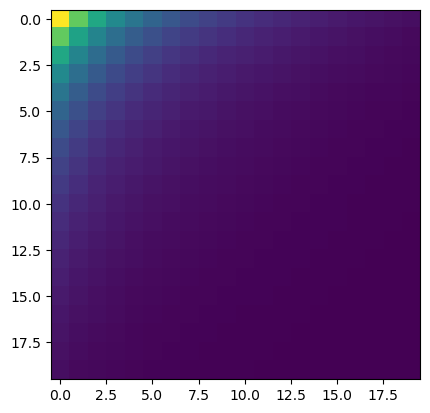

In [ ]:
plt.imshow(cl_cov_mat[:, :, 50])

In [1]:
plt.semilogy(cl_cov_mat[0, 0, :])

NameError: name 'plt' is not defined

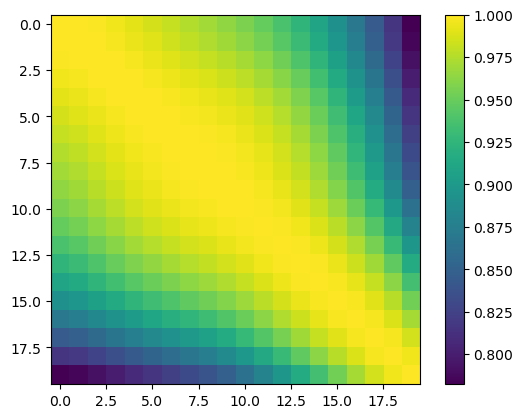

In [ ]:
my_l = 100
tmp = 0*cl_cov_mat[:, :, my_l]

for i in range(len(freqs)):
    for j in range(len(freqs)):
        tmp[i, j] = cl_cov_mat[i, j, my_l]/np.sqrt(cl_cov_mat[i, i, my_l]*cl_cov_mat[j, j, my_l])

im = plt.imshow(tmp)
plt.colorbar(im)

In [ ]:
e, v = np.linalg.eigh(tmp)
print(e/(e[-1]))

[8.82967855e-16 1.09443036e-15 1.10554319e-15 1.14020983e-15
 1.22018854e-15 1.36249136e-15 1.42439667e-15 1.78142381e-15
 2.45451223e-15 3.40965604e-15 5.59702228e-15 1.06182863e-14
 1.89395318e-14 2.52480811e-14 1.08575586e-06 2.27063755e-06
 3.61139742e-04 2.22276549e-02 2.02186416e-01 1.00000000e+00]


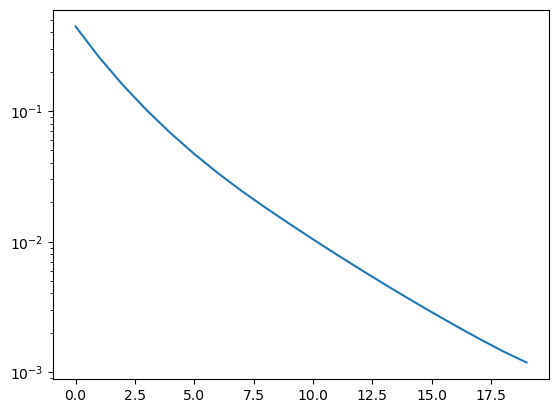

In [ ]:
plt.semilogy(np.diag(cl_cov_mat[:, :, 50]))

Mask the Galactic plane and repeat steps.. Can just create mask by trimming flux above a certain value.

In [ ]:
cov_mat = np.zeros((len(freqs), len(freqs)))

for i in range(len(freqs)):
    for j in range(len(freqs)):
        cov_mat[i, j] = np.mean(Cl_list[i] * Cl_list[j])

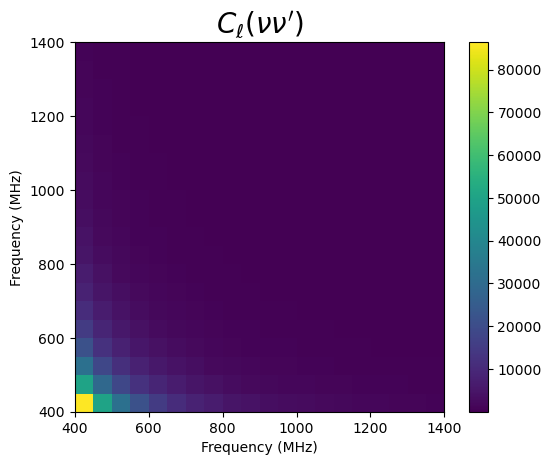

In [ ]:
im = plt.imshow(cov_mat, origin='lower', cmap='viridis',
                extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.colorbar()
plt.xlabel("Frequency (MHz)")
plt.ylabel("Frequency (MHz)")
plt.title(r"$C_{\ell}(\nu \nu')$", fontsize=20)
plt.show()
